# 0.0 IMPORTS


In [1]:
import pandas as pd
import numpy as np
import os
import inflection
import math
import seaborn as sns

from matplotlib import pyplot as plt

In [7]:
import markupsafe

In [2]:
os.chdir('/media/thiago/THIAGO1TB/Thiago/2022/data_science/seja_um_data_scientist/CDS/ds_em_producao/ds_producao_projeto/data')

## 0.1. Helper functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory = False) #low_memory = False loads the data at once. Set True to load data in chunks
df_store_raw = pd.read_csv( '../data/store.csv', low_memory = False)

#Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRICAO DOS DADOS 

In [3]:
df1 = df_raw.copy() # fazer uma cópia no inicio de cada sessão

## 1.1. Rename Columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 
'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# transforming column names from Camel to snakecase
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimension

In [5]:
print(f' Number of rows: {df1.shape[0]}')
print(f' Number of columns: {df1.shape[1]}')

 Number of rows: 1017209
 Number of columns: 18


## 1.3. Data types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NA

In [8]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else ( x ))

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'],axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'],axis=1 )

# promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'],axis=1 )

# promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'],axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive statistics

In [12]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [17]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


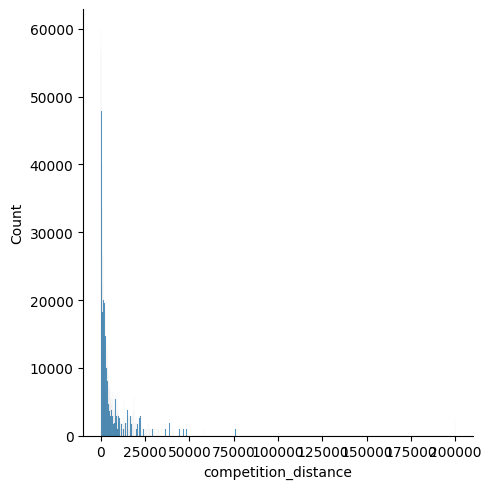

In [13]:
sns.displot(df1['competition_distance']);

### 1.7.2 Categorical attributes

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

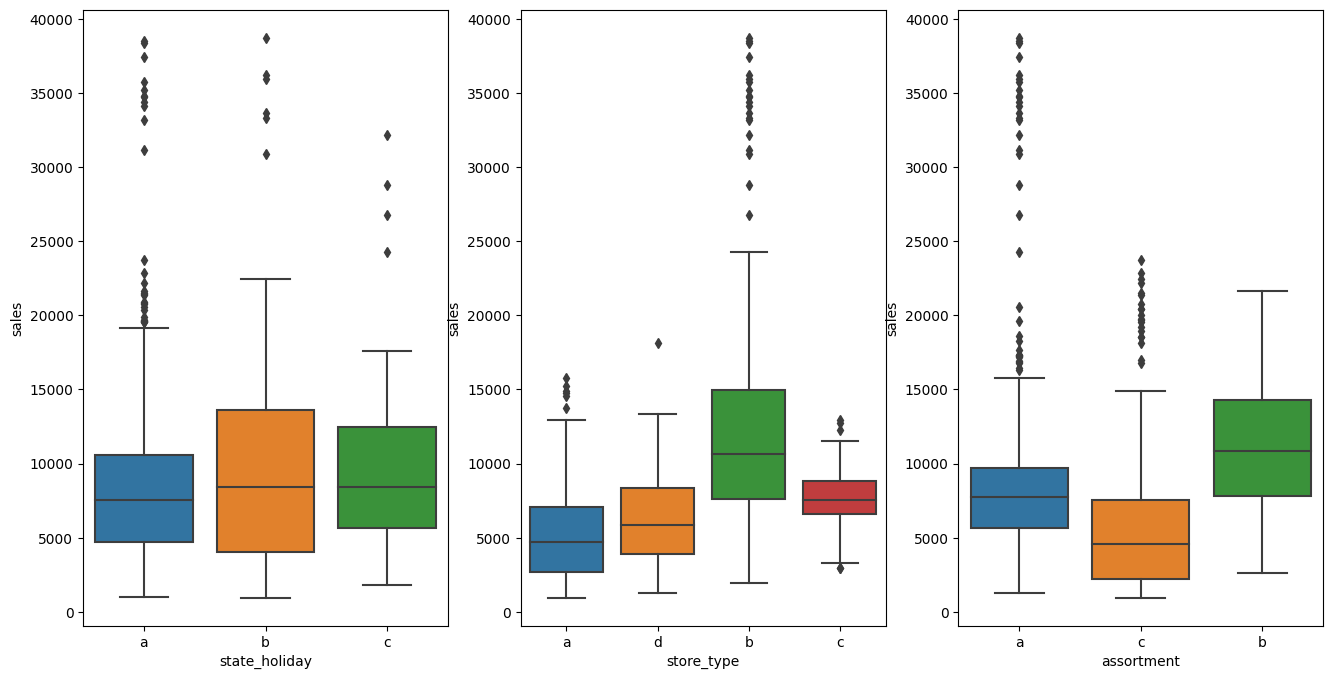

In [14]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(16,8))


plt.subplot( 1,3,1 )
sns.boxplot( x= 'state_holiday', y='sales' , data=aux1 );

plt.subplot( 1,3,2 )
sns.boxplot( x= 'store_type', y='sales' , data=aux1 );

plt.subplot( 1,3,3 )
sns.boxplot( x= 'assortment', y='sales' , data=aux1 );